In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.insert(0, '/content/drive/MyDrive/stat_project/analysis')

In [4]:
%cd /content/drive/MyDrive/stat_project/analysis

/content/drive/MyDrive/stat_project/analysis


In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error , mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import GridSearchCV




In [11]:
# Path to stock data CSV file
file_path = '/content/drive/MyDrive/stat_project/analysis/trainingset/FPT_stock_data.csv'
sentiment_file_path = '/content/drive/MyDrive/stat_project/analysis/trainingset/FPT_articles_data.csv'
data = pd.read_csv(file_path)

# Convert 'date' column to datetime format and handle any parsing errors
data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y', errors='coerce')

# Drop rows with failed 'date' conversion (i.e., NaT values)
data = data.dropna(subset=['date'])

# Sort data by 'date' in ascending order
data = data.sort_values(by='date')

# Reset the index for better readability
data.reset_index(drop=True, inplace=True)

# Keep only 'date' and 'close_price' columns
data = data[['date', 'close_price']]

# Set 'date' as the index
data.set_index('date', inplace=True)

# Create daily frequency and interpolate missing values
data = data.asfreq('D')
data['close_price'] = data['close_price'].interpolate()


# --- Filter data based on date range ---
# Input the start and end date
train_start_date = '2024-03-27'
train_end_date = '2024-11-01'
forecast_start_date = '2024-11-02'
forecast_end_date = '2024-12-31'

# Filter the data based on the given date range
filtered_data = data.loc[train_start_date:train_end_date]
filtered_data = filtered_data.asfreq('D')  # Gán tần suất hàng ngày
filtered_data['close_price'] = filtered_data['close_price'].interpolate()  # Nội suy giá trị thiếu


# Future data
future_data = data.loc[forecast_start_date:forecast_end_date]


# --- Integrate sentiment data ---
# Path to sentiment data CSV file
df_articles = pd.read_csv(sentiment_file_path)

df_articles['Date posted'] = df_articles['Date posted'].str.strip()
df_articles['Date posted'] = df_articles['Date posted'].str.replace(r'[^\w\s/-]', '', regex=True)

# Convert 'Date' column in sentiment data to datetime format
df_articles['Date'] = pd.to_datetime(df_articles['Date posted'], dayfirst=True, errors='coerce')

# Drop rows with failed 'Date' conversion
df_articles = df_articles.dropna(subset=['Date'])
df_articles = df_articles.sort_values(by='Date')
df_articles.set_index('Date', inplace=True)
# Normalize sentiment scores from 1-10 to -1 to 1
df_articles.loc[:, 'Normalized_Sentiment'] = (df_articles['Emotional Rating (1-10)'] - 5.5) / 4.5

# --- Combine data ---
# Merge sentiment data into filtered stock data on 'Date'
df_combined = filtered_data.join(df_articles[['Normalized_Sentiment']], how='left')
df_combined = df_combined.asfreq('D')

# Fill missing sentiment values (if necessary)
df_combined['close_price'] = df_combined['close_price'].interpolate()
df_combined['Normalized_Sentiment'] = df_combined['Normalized_Sentiment'].interpolate()

# Prepare exogenous data for the future
## Give last value of exog into training set
last_exog_value = df_combined.loc[train_start_date:train_end_date, 'Normalized_Sentiment'].iloc[-1]
future_sentiment = df_articles[['Normalized_Sentiment']].loc[forecast_start_date:forecast_end_date]
future_sentiment = future_sentiment.reindex(pd.date_range(start='2024-11-02', end=forecast_end_date, freq='D'))
# Fill missing values before the date with the last value from the training set
future_sentiment['Normalized_Sentiment'] = future_sentiment['Normalized_Sentiment'].fillna(last_exog_value)
# Interpolate if necessary (in case there are gaps between days)
future_sentiment['Normalized_Sentiment'] = future_sentiment['Normalized_Sentiment'].interpolate(method='linear')
# Fill values after the last known date with the last known value
future_sentiment['Normalized_Sentiment'] = future_sentiment['Normalized_Sentiment'].ffill()

# Print the training and testing data
print("Training and testing data:")
print(df_combined.head())
print("\nFuture exogenous data:")
print(future_sentiment.head())




Training and testing data:
            close_price  Normalized_Sentiment
date                                         
2024-03-27        115.2              0.555556
2024-03-28        117.1              0.553216
2024-03-29        116.5              0.550877
2024-03-30        116.6              0.548538
2024-03-31        116.7              0.546199

Future exogenous data:
            Normalized_Sentiment
2024-11-02              0.555556
2024-11-03              0.555556
2024-11-04              0.555556
2024-11-05              0.333333
2024-11-06              0.555556


In [12]:
# Define the dependent variable and exogenous variables
y = df_combined['close_price']
x_exog = df_combined[['Normalized_Sentiment']]
x_exog = x_exog.assign(**x_exog.fillna(x_exog.mean()))

# Assume y is a time series and x_exog are exogenous variables
train_size = int(0.8*len(df_combined))
y_train = df_combined['close_price'][:train_size]
y_test = df_combined['close_price'][train_size:]
x_exog_train = df_combined[['Normalized_Sentiment']][:train_size]
x_exog_test = df_combined[['Normalized_Sentiment']][train_size:]

# Training and test splits are already set in the code
x_train = x_exog_train
y_train = y_train
x_test = x_exog_test
y_test = y_test

# Set the parameters to optimize
param_grid = {
    'n_estimators': [100, 200, 300],         # Number of trees in the forest
    'max_depth': [10, 20, None],             # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],         # Minimum number of samples to split a node
    'min_samples_leaf': [1, 2, 4],           # Minimum number of samples in a leaf
    'max_features': ['sqrt', 'log2']         # Maximum number of features to consider when splitting a node
}

# Initialize the Random Forest model
rf = RandomForestRegressor(random_state=42)

# Use GridSearchCV to find the optimal parameters
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Train the GridSearchCV
grid_search.fit(x_train, y_train)

# Print the best parameters found
print("\n--- Best Parameters Found ---")
print(grid_search.best_params_)

# Get the best model from GridSearch
best_rf = grid_search.best_estimator_

# --- Prediction ---
y_pred = best_rf.predict(x_test)

# --- Model Evaluation ---
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("\n--- Model Evaluation Metrics After GridSearch ---")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")


Fitting 3 folds for each of 162 candidates, totalling 486 fits

--- Best Parameters Found ---
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}

--- Model Evaluation Metrics After GridSearch ---
Mean Absolute Error (MAE): 20.74
Mean Squared Error (MSE): 433.51
Root Mean Squared Error (RMSE): 20.82
Mean Absolute Percentage Error (MAPE): 15.31%


In [13]:
# Save results
results_df = pd.DataFrame({
    'Date': y_test.index,
    'Actual_Close_Price': y_test.values,
    'Predicted_Close_Price': y_pred
})
output_path = '/content/drive/MyDrive/stat_project/analysis/results/forecast_60days_random_forest.csv'
results_df.to_csv(output_path, index=False)

print(f"Kết quả dự báo đã được lưu vào: {output_path}")

Kết quả dự báo đã được lưu vào: /content/drive/MyDrive/stat_project/analysis/results/forecast_60days_random_forest.csv


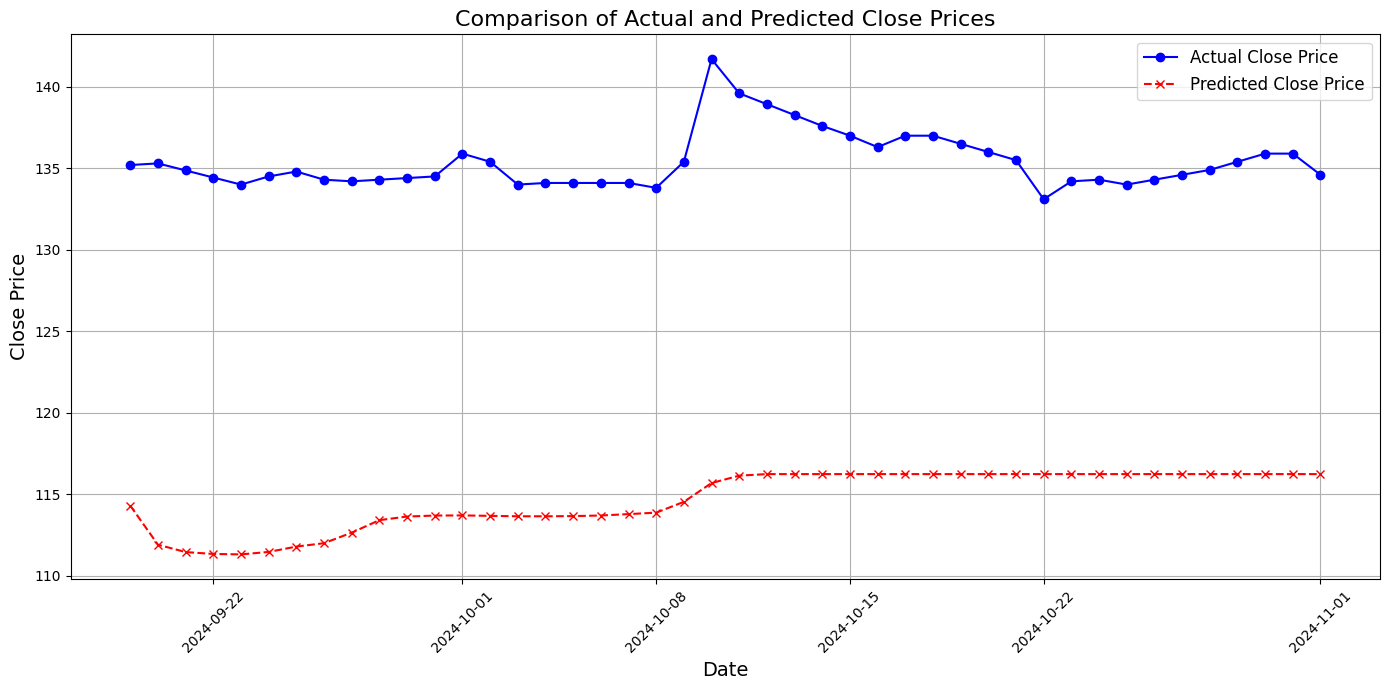

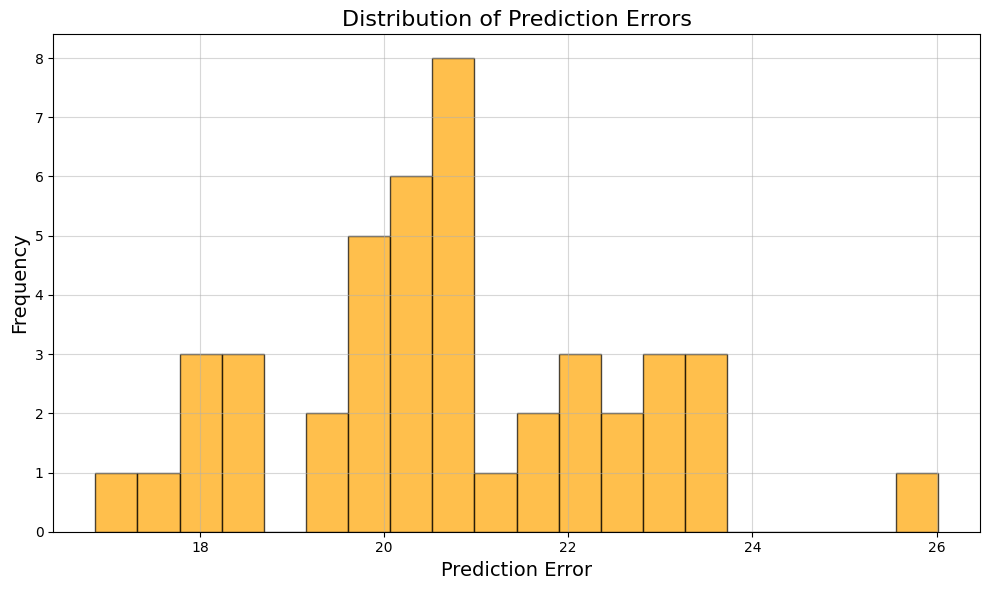

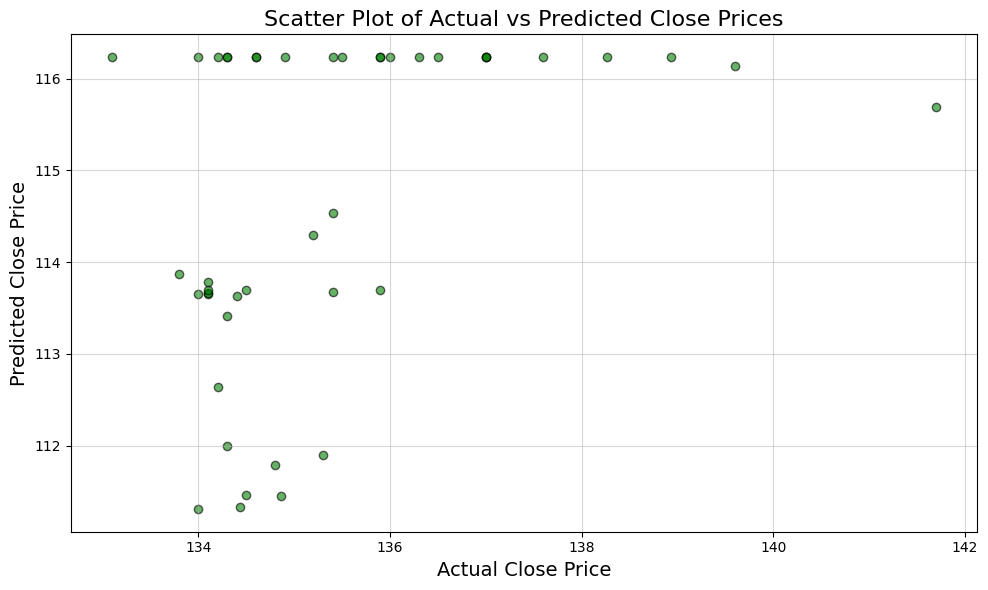

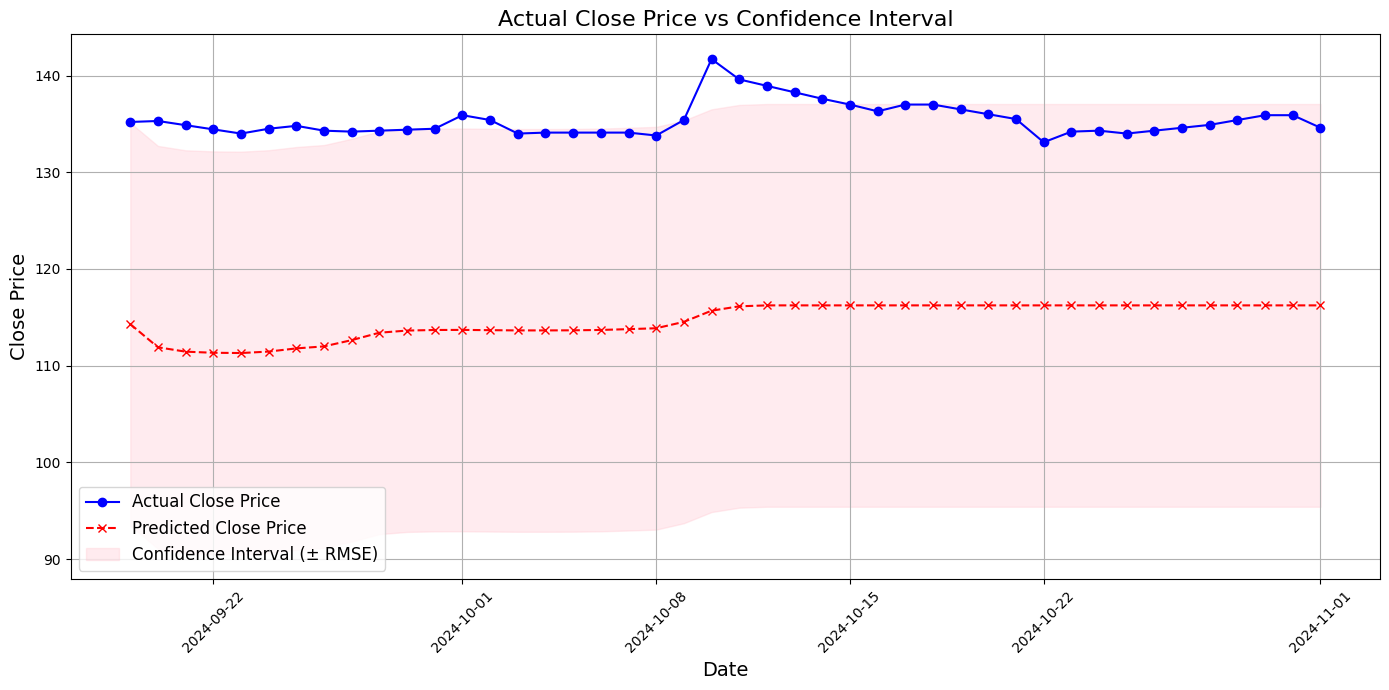

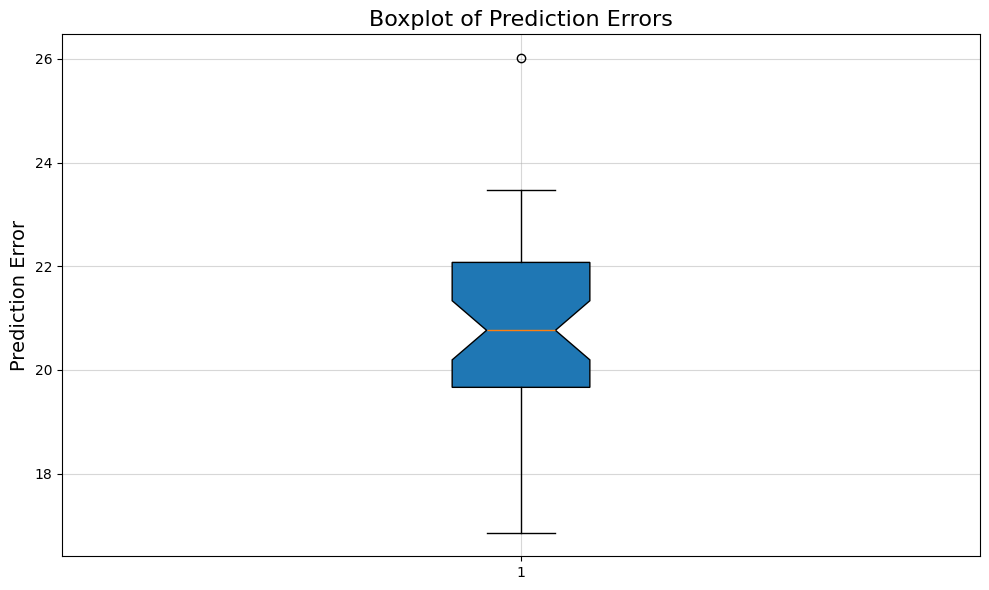

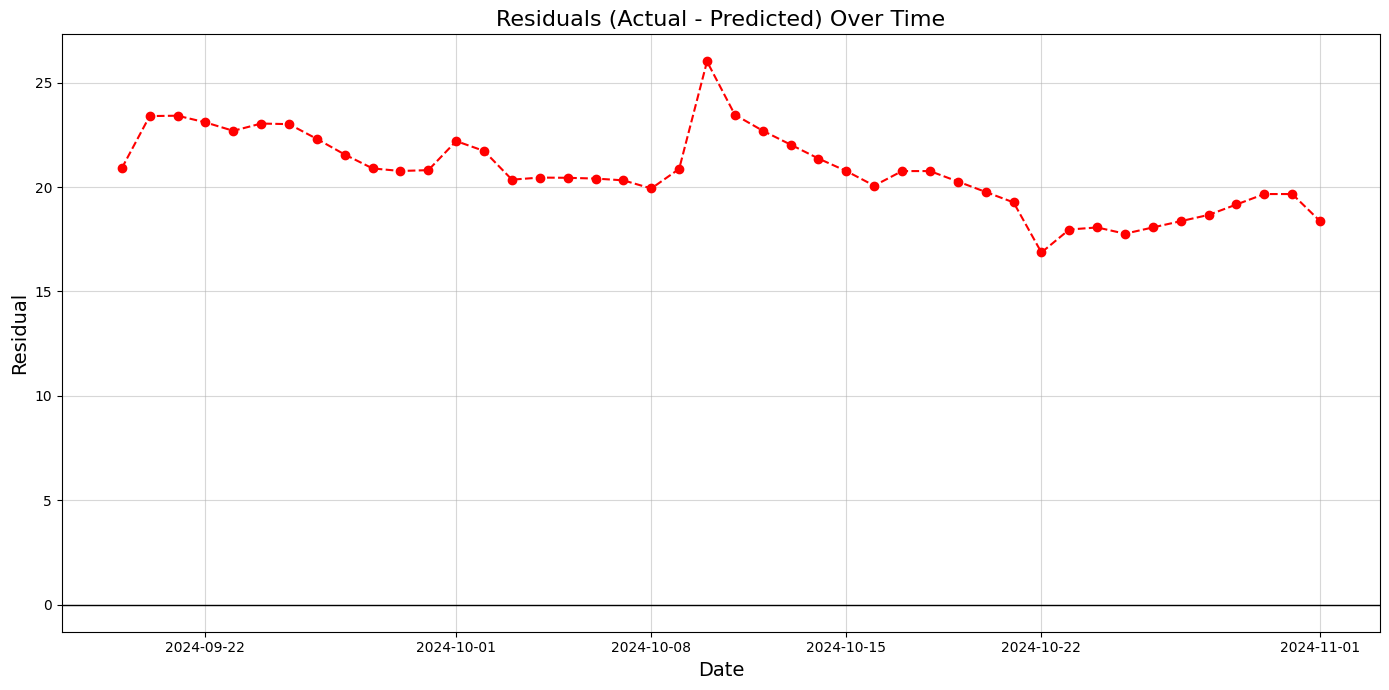

In [14]:
# 1. Comparison Chart of Actual and Predicted Values
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual Close Price', color='blue', marker='o')
plt.plot(y_test.index, y_pred, label='Predicted Close Price', color='red', linestyle='--', marker='x')
plt.title('Comparison of Actual and Predicted Close Prices', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Histogram of Prediction Errors
# Calculate prediction errors
prediction_errors = y_test - y_pred

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(prediction_errors, bins=20, color='orange', alpha=0.7, edgecolor='black')
plt.title('Distribution of Prediction Errors', fontsize=16)
plt.xlabel('Prediction Error', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

# 3. Scatter Plot of Actual vs Predicted Values
# Plot scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='green', alpha=0.6, edgecolor='black')
plt.title('Scatter Plot of Actual vs Predicted Close Prices', fontsize=16)
plt.xlabel('Actual Close Price', fontsize=14)
plt.ylabel('Predicted Close Price', fontsize=14)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

# 4. Actual Values vs Confidence Interval (Actual vs Confidence Interval)
# Create confidence interval ± RMSE
lower_bound = y_pred - rmse
upper_bound = y_pred + rmse

# Plot chart
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual Close Price', color='blue', marker='o')
plt.plot(y_test.index, y_pred, label='Predicted Close Price', color='red', linestyle='--', marker='x')

# Plot confidence interval
plt.fill_between(y_test.index, lower_bound, upper_bound, color='pink', alpha=0.3, label='Confidence Interval (± RMSE)')

plt.title('Actual Close Price vs Confidence Interval', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5. Boxplot to Compare Prediction Errors
# Plot Boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(prediction_errors, patch_artist=True, notch=True)
plt.title('Boxplot of Prediction Errors', fontsize=16)
plt.ylabel('Prediction Error', fontsize=14)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

# 6. Residual Plot (Actual - Predicted) Over Time
# Plot residuals
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, prediction_errors, color='red', marker='o', linestyle='--')
plt.axhline(0, color='black', linestyle='-', linewidth=1)
plt.title('Residuals (Actual - Predicted) Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Residual', fontsize=14)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()
